In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [60]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import os

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'ypp',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

We make usage of the core databases generated by Andrea and located in 

In [4]:
core_dbs = '/work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs'
os.listdir(core_dbs)

['12x12x3',
 '16x16x4',
 '9x9x1',
 'PW.gitlab',
 'known_hosts',
 '9x9x1_p',
 '12x12x3_p']

# Analysis of the band structure of the WSe$_2$

We compute the dft band stucture.

Valence bands are the 51 and 52.

In [5]:
run_path = 'BANDS'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [6]:
k = kpoints[1]
source_dir = os.path.join(core_dbs,k,'SAVE')
run_dir = os.path.join(run_path,k)
Tools.init_yambo_run_dir(source_dir,run_dir=run_dir)

SAVE folder already present in BANDS/12x12x3. No operations performed.


We include bands from 47 to 56, so in this range valence bands are 4 and 5

In [48]:
band_range = [47,56]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]
GfnQP_E = {'9x9x1' :  [0.25,1.,1.], '12x12x3' : [0.18,1.,1.], '16x16x4' : [0.0,1,1.2]}


study = D.Dataset(run_dir=run_dir,num_tasks=2,skip=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_array_variables(GfnQP_E=GfnQP_E[k])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20,'']
study.append_run(id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 2 parallel tasks


In [49]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BANDS/12x12x3',
 'num_tasks': 2,
 'verbose': True,
 'skip': True,
 'input': {'args': 'mpirun -np 1 ypp -s b -V qp',
  'folder': 'BANDS/12x12x3',
  'filename': 'ypp.in',
  'arguments': [],
  'variables': {'INTERP_Shell_Fac': [20, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [20, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'GfnQPdb': 'none',
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_Z': [(1+0j), ''],
   'BANDS_bands': [[47, 56], ''],
   'GfnQP_E': [[0.18, 1.0, 1.0], ''],
   'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
   'GfnQP_Wc': [[0.0, 0.0, 0.0], ''],
   'BANDS_kpts': [[[0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0],
     [0.3333333333333333, 0.333333

In [36]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: BANDS/12x12x3/job_ypp_bands_dft_boltz.out
delete folder: BANDS/12x12x3/ypp_bands_dft_boltz
run command: mpirun -np 16 ypp -F ypp_bands_dft_boltz.in -J ypp_bands_dft_boltz -C ypp_bands_dft_boltz
slurm submit:  cd BANDS/12x12x3 ; sbatch job_ypp_bands_dft_boltz.sh
computation ypp_bands_dft_boltz is running...
computation ypp_bands_dft_boltz ended
Run performed in 03s
Task [0] ended 
 


In [50]:
bands = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'WSe$_2$ bands')

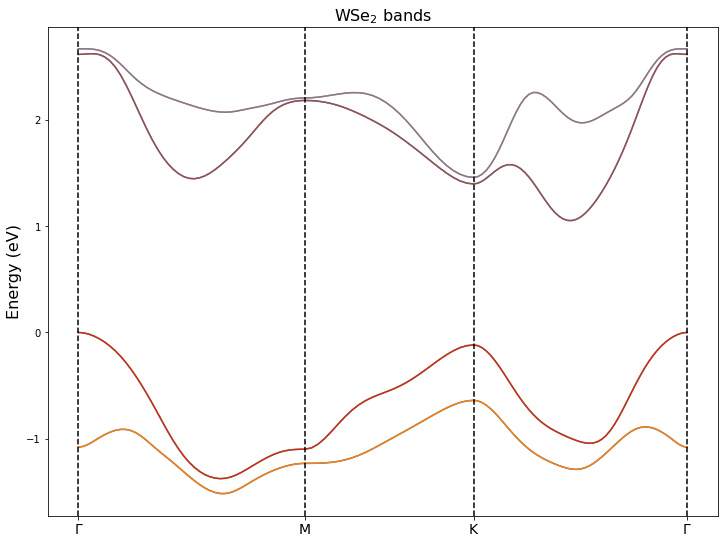

In [51]:
fig, ax = plt.subplots(figsize=(12, 9))
bands.plot(plt,selection=[2,3,4,5,6,7,8,9],linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('WSe$_2$ bands',size=16)

We compute the gap at K

In [52]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.3440817278312105, 0.872677740669527, 0.49999994])

In [61]:
path = bands.get_path()
ind_K = np.where(path == bands.get_high_sym_positions()[1][2])[0][0]
ind_K

68

In [59]:
val,cond = bands.bands[5],bands.bands[6]
gap_K = cond[ind_K]-val[ind_K]
gap_K

1.514436382

We also studyy the energy of the K-valley transitions. To do so we compute the k position (on the path) 
of the conduction minimum in the K valley

In [67]:
cond_min_ind = argrelextrema(-cond,np.greater,order=3)[0]
cond_min = path[cond_min_ind]
cond_min_ind,cond_min

(array([22, 68, 91]), array([0.25581393, 0.87267774, 1.08952356]))

The minimum in the K valley corresponds to path=1.089, realized for the con_min_ind=91

In [68]:
gap_Kvalley = cond[cond_min_ind]-val[cond_min_ind]
gap_Kvalley

array([2.71382213, 1.51443638, 2.05195743])

so the gap in the K valley is 2.05 eV.